## LangGraph
*에이전트* 및 *멀티에이전트 워크플로우* 를 만드는 데 사용되는 LLM.<br>
*상태저장, 멀티 액터* 애플리케이션을 구축하기 위한 라이브러리. <br>

*주기(Cycle), 제어가능성, 지속성* 이라는 핵심 이점 제공. 대부분의 에이전트 아키텍처에 필수적인 *주기를 포함하는 플로우를 정의할 수 있어 DAG 기반 솔루션과 차별화*<br>
애플리케이션의 흐름과 상태 모두 세밀하게 제어할 수 있어 안정적인 에이전트를 만드는데 도움. 지속성이 내장되어 있어 고급 휴먼 인더 루프 및 메모리 기능을 사용 가능.<br>

In [6]:
from dotenv import load_dotenv
from langchain_teddynote import logging

logging.langsmith("LANGGRAPH")
load_dotenv()



LangSmith 추적을 시작합니다.
[프로젝트명]
LANGGRAPH


True

## 노드와 엣지
- GraphState(상태 저장 그래프)
    - 그래프의 각 노드가 계산의 단계를 나타내며, 그래프는 계산이 진행됨에 따라 전달되고 업데이트되는 상태를 유지하는 상태 저장 그래프 개념을 중심으로 작동.
- Node(노드)
    - 각 노드는 함수 또는 계산 단계를 나타냄. 입력 처리, 의사 결정, 외부 API와의 상호 작용 등 특정 작업을 수행하도록 노드를 정의할 수 있다.
- Edge(엣지)
    - 노드를 연결하여 계산의 흐름을 정의. 조건부 엣지를 지원, 그래프의 현재 상태에 따라 실행할 다음 노드를 동적으로 결정할 수 있다.

GraphState

In [7]:
from typing import TypedDict

class GraphState(TypedDict):
    goal: str # 목표
    todo: list[str] # 할 일 목록
    current_job: str # 현재 작업
    total_time: int # 총 소요시간(시간)
    time_spent: int # 소요시간(시간)
    status: str # 상태(진행중, 다음 작업, 종료)

Node & Edge

In [8]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import CommaSeparatedListOutputParser
from rag.utils import format_task


def create_todo_list(goal: str):
    output_parser = CommaSeparatedListOutputParser()
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", 
             "당신은 나의 할일을 관리하는 비서입니다. 당신의 임무는 나를 위하여 주어진 목표에 대하여 할일 목록을 작성하는 것 입니다.",
            ),
            ("human",
             "주어진 목표(goal)를 잘 수행하기 위하여 할일 목록을 작성해 주세요. '할일:걸리는시간(hour)' 으로 작성하세요. 걸리는 시간은 반올림하여 int 로 작성하세요.\n\n#목표: {goal}\n\n#형식: {format_instuctions}",
            ),
        ]
    )
    prompt = prompt.partial(format_instuctions=output_parser.get_format_instructions())
    llm = ChatOpenAI(model_name="gpt-4-turbo")
    chain = prompt | llm | CommaSeparatedListOutputParser()

    output = chain.invoke({"goal": goal})
    return output

In [9]:
todo = create_todo_list("LangChain 튜토리얼로 RAG 공부하기")
todo

['LangChain 공식 사이트 방문:1',
 'RAG 개념 이해를 위한 문서 읽기:2',
 '튜토리얼 실습 환경 설정:1',
 '튜토리얼 실습 따라하기:3',
 '실습 내용 복습 및 추가 질문 정리:1']

각 노드의 세부 기능 정의

In [10]:
def list_todo(state: GraphState) -> GraphState:
    goal = state["goal"]
    # 할 일 목록 생성
    todo = create_todo_list(goal)
    # 할 일 목록을 포맷팅
    todo = format_task(todo)

    return GraphState(todo=todo)


def start_job(state: GraphState) -> GraphState:
    todo = state["todo"]
    if len(todo):
        current_job, total_time = todo.pop(0)
        status = "진행중"
        time_spent = 0
    return GraphState(
        current_job=current_job,
        total_time=total_time,
        time_spent=time_spent,
        status=status,
    )

def process_job(state: GraphState) -> GraphState:
    time_spent = state["time_spent"]
    time_spent += 1

    return GraphState(time_spent=time_spent)


def check_process(state: GraphState) -> GraphState:
    if state["time_spent"] >= state["total_time"]:
        status = "다음 작업"
        if len(state["todo"]) == 0:
            status = "종료"
    else:
        status = "진행중"
    return GraphState(status=status)

def next_step(state: GraphState) -> GraphState:
    return state["status"]

그래프 정의

In [15]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END 가져오기.
workflow = StateGraph(GraphState)

# 각 노드를 그래프에 추가
workflow.add_node("list_todo", list_todo) # 할일 목록 생성  
workflow.add_node("start_job", start_job) # 작업 시작
workflow.add_node("process_job", process_job) # 작업 진행
workflow.add_node("check_process", check_process) # 작업 체크

# 각 노드 연걸
workflow.add_edge("list_todo", "start_job")
workflow.add_edge("start_job", "process_job")
workflow.add_edge("process_job", "check_process")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "check_process",
    next_step,
    {
        "진행중": "process_job",
        "다음 작업": "start_job",
        "종료": END,
    },
)

# 그래프 시작점 정의
workflow.set_entry_point("list_todo")

# 기록을 위한 메모리 저장소 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer = memory)

그래프 시각화

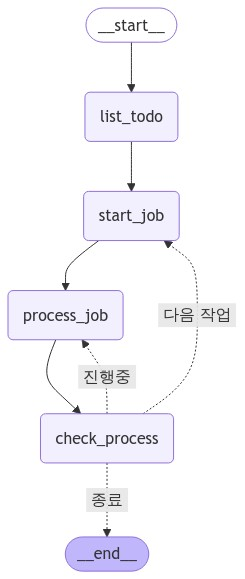

In [16]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )

except:
    pass

In [17]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})

# GraphState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(goal="랭체인(LangChain) 밋업에서 발표자료를 준비하기")

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"[NODE] {key}")
            for k, v in value.items():
                pprint.pprint(f"<{k}> {v}")
            pprint.pprint("===" * 10)
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

'[NODE] list_todo'
("<todo> [('주제 선정 및 자료 조사', 4), ('발표 구성 초안 작성', 2), ('PPT 슬라이드 제작', 3), ('발표 "
 "연습', 2), ('최종 검토 및 수정', 1)]")
'=============================='
'[NODE] start_job'
'<current_job> 주제 선정 및 자료 조사'
'<total_time> 4'
'<time_spent> 0'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 1'
'=============================='
'[NODE] check_process'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 2'
'=============================='
'[NODE] check_process'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 3'
'=============================='
'[NODE] check_process'
'<status> 진행중'
'=============================='
'[NODE] process_job'
'<time_spent> 4'
'=============================='
'[NODE] check_process'
'<status> 다음 작업'
'=============================='
'[NODE] start_job'
'<current_job> 발표 구성 초안 작성'
'<total_time> 2'
'<time_spent> 0'
'<status> 진행중'
'=============================='
'[NODE]